In [2]:
import numpy as np
import flopy
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os
import csv
import time
from scipy.stats import pearsonr
from flopy.utils.sfroutputfile import SfrFile

from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import matplotlib.cm as cm

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Classifier
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV

import importlib
import treeFuncs
from treeFuncs import trainAndEvaluateModel 
from treeFuncs import metrics
from scipy import stats


modws ="C:/Users/davem/Documents/Thesis/modflow/mfoutput"
modws= "D:/mfoutput/transientDrawdown"
#modws= "D:/mfoutput/transientSeasons"

### Bring in data from MODFLOW files
First code block brings in the saved outputs (flows) from MODFLOW jupyter notebook and the parameters 
We set the number of stress periods we want to keep throughout the rest of the analysis (currently we take all of them so for constant pumping = 5, seasonal pumping = 21

In [25]:
col_names = ['K', 'Low_K_ratio', 'Sy', 'Rech', 'ET_valley', 'ET_rip_ratio', 'Stream_K_ratio','Pumping Rate']

# load output from modflow simulations
#outputdf = pd.read_csv('mf_notebooks/TransOutputStpSteadyPumpTest12.csv') 
outputdf = pd.read_csv('mf_notebooks/TransOutputStpSeasonalTest12.csv') #output
#outputdf = pd.read_csv('mf_notebooks/TransOutputStpSteadyPumpTest12WetLay.csv')
#load parameters
sampling = np.loadtxt("mf_notebooks/ModflowParams8-1000Test12.txt") 
#print(sampling)
pardf = pd.DataFrame(sampling, columns = col_names)

outputdf = outputdf[['simnum','Qout','reach','Stp']].reset_index() #only keep the cols we need

#Drawdown scenario steps
numTS = 5 #number of time steps to keep from the end
stps = 5 - numTS

#Seasonal Scenario Steps
numTS = 21 #number of time steps to keep from the end - keeping them all now
stps = 21 - numTS

StrPer = [i+1 for i in range(stps, stps+numTS)]
print(StrPer)
outputdf = outputdf[outputdf['Stp'] > stps].set_index(['Stp','simnum','reach']) #grab data from the last 5 stress periods and set index to simulation
simindex = outputdf.index.get_level_values('simnum').unique()
timestepidx = outputdf['index'].unique()
idx = pd.IndexSlice

pardfError = pardf.loc[~pardf.index.isin(simindex)]
pardf = pardf.iloc[simindex]
print("pardf shape: ", pardf.shape)
outputdf = outputdf.drop('index', axis=1).unstack('reach')
print(outputdf.shape)

outputdf = outputdf.droplevel(0, axis=1)
display(outputdf)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
pardf shape:  (678, 8)
(14224, 50)


reach          1    2    3    4    5    6    7    8    9    10  ...       41  \
Stp simnum                                                      ...            
1   0       100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  4356.60   
    1       100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6993.40   
    2       100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6464.80   
    3       100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.00   
    5       100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9910.40   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...      ...   
21  993     100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.00   
    994     100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6407.20   
    995     100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5368.60   
    997     100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.00   
    998     100.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   398.48   

reach             42        43        44        45        46       47  \
Stp simnum                                                              
1   0        4440.40   4512.70   4572.80   4620.00   4653.20   4670.9   
    1        7121.00   7229.20   7316.50   7380.60   7418.50   7425.1   
    2        6579.90   6678.50   6759.80   6822.70   6865.50   6885.9   
    3           0.00      0.00      0.00      0.00      0.00      0.0   
    5       10109.00  10278.00  10417.00  10523.00  10596.00  10632.0   
...              ...       ...       ...       ...       ...      ...   
21  993         0.00      0.00      0.00      0.00      0.00      0.0   
    994      6491.20   6568.50   6635.90   6690.00   6727.80   6745.9   
    995      5448.30   5520.10   5580.40   5625.20   5650.10   5649.1   
    997         0.00      0.00      0.00      0.00      0.00      0.0   
    998       425.24    451.63    475.96    496.62    511.98    520.3   

reach             48        49        50  
Stp simnum                                
1   0        4670.40   4644.30   4644.30  
    1        7389.80   7277.40   7277.40  
    2        6879.10   6819.20   6819.20  
    3           0.00      0.00      0.00  
    5       10628.00  10572.00  10572.00  
...              ...       ...       ...  
21  993         0.00      0.00      0.00  
    994      6738.60   6676.50   6676.50  
    995      5612.00   5506.40   5506.40  
    997         0.00      0.00      0.00  
    998       518.85    497.13    497.15  

[14224 rows x 50 columns]

In [7]:
display(pardfError.index)
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
print("Pars that did not converge:")
display(pardfError.describe())
print("Pars that converge:")
display(pardf.describe())

bins = [1,2,3,4,5]
labels = [f'{i+.1}-{j}' for i, j in zip(bins[:-1], bins[1:])] 

s = pd.cut(pardf['Pumping Rate'], bins = bins, labels = labels)
df = pardf.groupby(s)[pardf.columns[:-1]].count().reset_index()
print(df)
s = pd.cut(pardfError['Pumping Rate'], bins = bins, labels = labels)
dfEr = pardfError.groupby(s)[pardfError.columns[:-1]].count().reset_index()
print(dfEr)
#print(pardfError.groupby('K').mean())
# for i in pardf.columns[1:]:
#     plt.title(str(i))
#     plt.scatter(pardfError[i],pardfError['Rech'],pardfError['K'])
#     plt.scatter(pardf[i],pardf['Rech'],pardf['K'])
#    # plt.xscale('log')
#     if i in ['Low_K_ratio', 'Rech']:
#         plt.yscale('log')
#     plt.show()

Int64Index([  9,  12,  14,  16,  19,  22,  25,  32,  35,  39,
            ...
            924, 927, 935, 936, 937, 948, 952, 961, 966, 975],
           dtype='int64', length=179)

Pars that did not converge:


,K,Low_K_ratio,Sy,Rech,ET_valley,ET_rip_ratio,Stream_K_ratio,Pumping Rate
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,23.541212,0.144871,0.269892,0.001982,0.000040,3.041560,5.328510,3.067275
std,13.247673,0.229675,0.127874,0.000706,0.000026,1.170730,2.532529,1.152418
min,2.528170,0.001013,0.052648,0.001002,0.000010,1.024032,1.010559,1.003866
25%,12.005419,0.007232,0.163837,0.001384,0.000018,2.070045,3.181248,2.088384
50%,22.944302,0.029586,0.267910,0.001816,0.000032,3.061424,5.337902,2.971678
75%,33.512194,0.184587,0.379234,0.002456,0.000056,4.021948,7.506729,4.162703
max,49.912564,0.973962,0.491588,0.003474,0.000100,4.977772,9.908674,4.990090


Pars that converge:


,K,Low_K_ratio,Sy,Rech,ET_valley,ET_rip_ratio,Stream_K_ratio,Pumping Rate
count,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000,821.000000
mean,26.535521,0.144555,0.276115,0.001999,0.000039,2.990981,5.537402,2.985279
std,13.944086,0.226492,0.130471,0.000715,0.000025,1.152354,2.613724,1.155995
min,2.045852,0.001006,0.050007,0.001001,0.000010,1.001218,1.005096,1.007320
25%,14.695710,0.005501,0.162179,0.001367,0.000018,1.987853,3.299971,1.970552
50%,26.629805,0.032530,0.277254,0.001882,0.000032,2.987670,5.561394,3.003498
75%,38.683089,0.177780,0.389956,0.002561,0.000056,3.989893,7.815052,3.974368
max,49.977172,0.996507,0.499704,0.003496,0.000099,4.999546,9.997111,4.996358


  Pumping Rate    K  Low_K_ratio   Sy  Rech  ET_valley  ET_rip_ratio  \
0        1.1-2  210          210  210   210        210           210   
1        2.1-3  200          200  200   200        200           200   
2        3.1-4  211          211  211   211        211           211   
3        4.1-5  200          200  200   200        200           200   

   Stream_K_ratio  
0             210  
1             200  
2             211  
3             200  
  Pumping Rate   K  Low_K_ratio  Sy  Rech  ET_valley  ET_rip_ratio  \
0        1.1-2  40           40  40    40         40            40   
1        2.1-3  50           50  50    50         50            50   
2        3.1-4  39           39  39    39         39            39   
3        4.1-5  50           50  50    50         50            50   

   Stream_K_ratio  
0              40  
1              50  
2              39  
3              50  


### Removing zero flow simulations 

From our definition of 'non-behavioral' - these are simulations that are dry essentially all the time. 
We find the wettest reach in the last time period and then remove any simulations that are dry. In the steady state scenario, this was several but in the transient this is usually just a few or none at all.

45
43
45
44
44
43
43
44
45
44
43
41
45
43
44
44
45
41
42
41
42


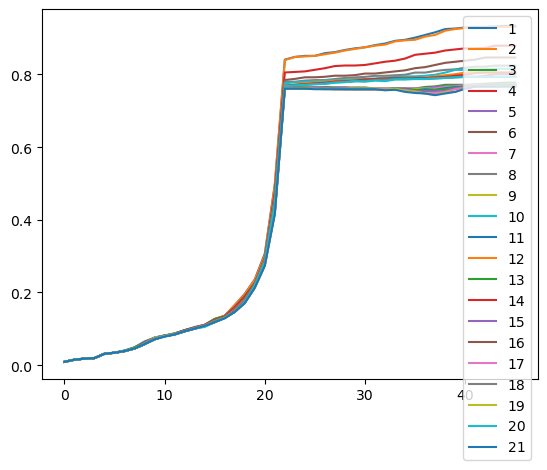

Stp  simnum
1    0          4572.80
     1          7316.50
     2          6759.80
     5         10417.00
     6          7865.40
                 ...   
     991         138.68
     993         635.62
     994       12199.00
     995       10166.00
     998        2664.90
Name: 44, Length: 631, dtype: float64

631


In [26]:
#Getting rid of ensembles with 0 flow
rn = 25

for i in StrPer:
    ReachQdf = outputdf.xs(i,level='Stp')

    numgrz = [np.sum(ReachQdf[k] > 0) / len(ReachQdf.index) for k in range(1,51)] 
    print(numgrz[1:].index(max(numgrz[1:])))
    plt.plot(numgrz[2:48], label=i)
    #print(ReachQdf.shape)
plt.legend()
#print(numgrz.index(max(numgrz)))
plt.show()
#print(ReachQdf.index)
rn_highest = numgrz.index(max(numgrz[1:]))#find reach with greatest number of wet ensembles (from the last stressperiod)
#print(numgrz[rn_highest])
#print(numgrz)
#ReachQdf = ReachQdf[ReachQdf[rn_highest] > 0]
#print(rn_highest)
#print(ReachQdf.shape)

#New way of pulling out simulations that are dry using multi-level index
idx = pd.IndexSlice #makes slicing multilevel indexs easier
HighRn = outputdf.loc[idx[StrPer[0],:],rn_highest+1]#get a slice of the highest reach (add 1 because reaches are 1-based) Qout (note in some instances the 0 stp had more sims so only lookng at last stp)
display(HighRn[HighRn > 0])
grtzSims = HighRn[HighRn > 0].index.get_level_values('simnum').unique().values #greater than zero simulations grtzSims
#print(grtzSims)
#pull out fist seasonal b/c it's not working
grtzSims = grtzSims[:]
print(len(grtzSims))
RevisedOutputdf = outputdf.loc[idx[:,grtzSims,:] , :]
#display(RevisedOutputdf)
#display(outputdf)
#pardf = pardf.loc[grtzSims]

# for l in StrPer:
#     LastStpQdf = outputdf.xs(l,level='Stp')
#     for i in LastStpQdf.index:
#         LastStpQdf.loc[i].plot(title="Streamflows for Stress Period " + str(l))
#     plt.show()

## Now for the Wells

In [6]:
#load in Ibound and find active cells in model - then put it into a list of well locations
ibound = np.loadtxt('base/ibound_lyr1.txt')            
all_well_loc = np.asarray(np.where(ibound == 1)).T

#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))
well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))

print(well_head.shape)

(2012, 713, 5)


In [117]:
# #Cell block for test head object out put - can ignore 

# modelname = "ScenarioSfr750Seasons_"+str(simindex[0])
# headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
# head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
# print(head.shape)
# print(head[::30,21,32][-6:])
# headtimes = np.array(headobj.get_times())
# print(headtimes)

# print(headtimes[::30])
# print(len(headtimes[::30]))

# headts = headobj.get_ts([(0,21,32)])
# #headts[10:,0] = (headts[10:,0] / 6) * 50  *2
# print(headts[::30][-numTS:].astype('int'))
# print(headobj.get_ts([(0,21,32)])[::30,1][-numTS:].astype('int'))


# print(len(headts))
# headstp = np.divmod(np.arange(len(headts)-10),30*2)[0]+1

# plt.plot(headts[::30,1])
# plt.show()
# plt.plot(headts[:,1])

In [118]:
#Get Head data for All active wells

#previously used the error list from the modflow output now just use the greater than zero sim list from above (grtzSims)
# error_list = np.loadtxt('mf_notebooks/ErrorSeasons_Sfr1000Test9.txt')
# #print(error_list)
# #sampling = np.loadtxt("ModflowParams7-750Test12.txt")
# ss_well_head_df= pd.read_pickle('outputs/heads/WellHead_SS1000test9.pkl')
# n = ss_well_head_df.index.values
# n2 = np.setdiff1d(n, error_list[:,0].astype('int'))
# err = [0,3,8,16,32,52,53,60,64,65,74,76,79,89,90,95,96,102,108,113,115,146,147,159,163,165,168,175,185,189,219,227,228,230,232,236,258,260,270,274,282,284,285,286,287,292,298,302,305,307,308,311,312,317,320,324,325,333,335,344,347,369,373,383,386,396,400,414,421,433,438,439,440,452,459,463]
# error_list = np.asarray(error_list)
# n3 = np.setdiff1d(n2, err)

modws= "D:/mfoutput/transientSeasons"
#well_head = np.empty((all_well_loc.shape[0], len(simindex),numTS))


well_error_sim = []


for j, i in enumerate(grtzSims):
    modelname = "ScenarioSfr1000SeasonalTest12_"+str(i)
   # modelname = "ScenarioSfr1000SteadyPumpTest12_"+str(i)
    headobj = flopy.utils.binaryfile.HeadFile(modws+'/'+modelname+'.hds')
#     for k in range(all_well_loc.shape[0]):
#         well_head[k][j][:] = headobj.get_ts([(0,int(all_well_loc[k][0]),int(all_well_loc[k][1]))])[::30,1][-numTS:] #complicated way of getting all the heads (numTS) by sampling every 30 of the head ts foreach well
#         if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
#                 well_error_sim.append(i)              
   # print(i)            
    head = headobj.get_alldata(mflay = 0, nodata=-9.9998999e+02)
    for k in range(all_well_loc.shape[0]): #grabbing the last n Stress periods (-numTS)
           # well_head[k][j][:] = head[::30,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           # Seasons only reports 5 times a stress period, versus the orignal 30 - above 
            #print(i,k, head[::5,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:])
            well_head[k][j][:] = head[::5,int(all_well_loc[k][0]),int(all_well_loc[k][1])][-numTS:] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would 
           
        # well_head[k][j][1] = head[-1][0][int(all_well_loc[k][0])][int(all_well_loc[k][1])] #Data from the wells is at timestep 0 for first or -1, if we wanna grab the last two it would  be 60
            if (np.any(well_head[k][j][:]) < 0) or (np.any(well_head[k][j][:]) > 200) or np.any(np.isnan(well_head[k][j][:])):
                well_error_sim.append(i)
print("Done Pulling Heads") 

## Delete out simulations where well head is twice the average - no longer doing this
print(well_head.shape)
#print(well_head.transpose(1,0,2).reshape(len(simindex),well_head.shape[0]*numTS))
RevisedPardf = pardf.loc[~pardf.index.isin(np.unique(well_error_sim))]
#new_zone.head
well_head_df = pd.DataFrame(well_head.transpose(1,0,2).reshape(len(grtzSims),well_head.shape[0]*numTS),index=grtzSims)#, index = pardf.index) #put the wwells into an unput that has each stress period so now input os 4024 long
display(well_head_df)
print(len(well_head_df.index))

well_head_df.to_pickle('outputs/heads/Well_head_Seasons.pkl')
#RevisedPardf.to_pickle('params/Seasons_pardf.pkl')   
print(len(well_head_df.index))
print(RevisedPardf)

Done Pulling Heads
(2012, 630, 21)


,0,1,2,3,4,5,6,7,8,9,...,42242,42243,42244,42245,42246,42247,42248,42249,42250,42251
1,76.128395,76.128319,76.116692,76.068253,76.046860,76.008591,75.999306,75.971146,75.969673,75.947502,...,74.491127,74.488571,74.483093,74.481834,74.477448,74.477119,74.473503,74.473839,74.470772,74.471573
2,77.679085,77.679001,77.668610,77.578941,77.492874,77.388466,77.314781,77.231171,77.178650,77.114326,...,75.515076,75.495392,75.472473,75.456566,75.437294,75.424835,75.408775,75.399284,75.385925,75.378883
5,77.173698,77.173691,77.152618,77.064522,77.018806,76.944466,76.918701,76.862335,76.851173,76.806465,...,75.257797,75.251778,75.234848,75.232079,75.217911,75.217583,75.205482,75.206955,75.196373,75.199173
6,77.886688,77.886444,77.874878,77.823685,77.784698,77.733940,77.704819,77.665550,77.646935,77.616646,...,75.836342,75.828133,75.816971,75.810959,75.801781,75.797569,75.790001,75.787224,75.780907,75.779259
8,81.978439,81.977669,81.904297,81.754326,81.710976,81.616714,81.615707,81.550209,81.568710,81.516556,...,78.758377,78.758072,78.750801,78.752441,78.746620,78.749344,78.744331,78.747650,78.743080,78.746727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,71.804001,71.800133,71.509117,71.621300,71.419098,71.575073,71.395363,71.562881,71.389091,71.559662,...,71.081306,70.960899,71.081100,70.960793,71.081047,70.960762,71.081032,70.960754,71.081032,70.960754
993,72.152214,72.151100,71.336433,71.507286,70.954193,71.267937,70.805000,71.174232,70.746552,71.137505,...,70.665115,70.405731,70.659889,70.402473,70.657837,70.401192,70.657036,70.400688,70.656723,70.400497
994,80.272438,80.272377,80.267776,80.228401,80.179169,80.121712,80.071976,80.021896,79.982162,79.942429,...,77.603500,77.590294,77.576111,77.564758,77.552467,77.542984,77.532494,77.524734,77.515877,77.509636
995,76.940712,76.940590,76.927452,76.864220,76.832275,76.779625,76.763016,76.724014,76.718323,76.687881,...,75.075851,75.071404,75.063171,75.060600,75.054001,75.052834,75.047440,75.047295,75.042770,75.043350


630
630
             K  Low_K_ratio        Sy      Rech  ET_valley  ET_rip_ratio  \
0    10.281063     0.094490  0.445527  0.001191   0.000036      1.136652   
1    18.609482     0.285699  0.246176  0.001965   0.000012      3.580131   
2    12.623508     0.018242  0.253279  0.001663   0.000078      2.966885   
3    47.648054     0.026667  0.113496  0.001135   0.000014      4.445545   
5    26.315563     0.015436  0.350073  0.003023   0.000014      1.595550   
..         ...          ...       ...       ...        ...           ...   
993  31.791715     0.152635  0.061898  0.001105   0.000028      2.403018   
994  15.625849     0.006515  0.386968  0.002825   0.000079      3.784132   
995  21.748669     0.127295  0.308633  0.002601   0.000014      4.786857   
997  46.581917     0.008535  0.406704  0.001227   0.000090      1.815241   
998  34.853152     0.001927  0.127073  0.001650   0.000022      1.471811   

     Stream_K_ratio  Pumping Rate  
0          1.742393      2.878057  
1      

In [27]:
#Only necessary if not running previous cell and just want to pull well_head_df from pkl or csv

#well_head_df = pd.read_pickle('outputs/heads/Well_head_SteadyPump.pkl')
well_head_df = pd.read_pickle('outputs/heads/Well_head_Seasons.pkl')

#new_zone = pd.read_pickle('params/Drawdown_pardf.pkl')
#new_zone = pd.read_pickle('params/Seasons_pardf.pkl')

well_head = np.empty((all_well_loc.shape[0], len(grtzSims),numTS))
well_heads_loc = np.arange(all_well_loc.shape[0]*numTS).reshape((int(all_well_loc.shape[0]),numTS)) #splits the well head_df into subsets aplicable to the location (so we ahve numTS outputs)

wellnums_arr = np.arange(well_head.shape[0])
stps_arr = StrPer
column_idx = pd.MultiIndex.from_product([wellnums_arr.astype('str'), stps_arr],
                           names=['wellnum', 'Stp'])
well_head_df.columns = column_idx

display(well_head_df)

wellnum          0                                                         \
Stp             1          2          3          4          5          6    
1        76.128395  76.128319  76.116692  76.068253  76.046860  76.008591   
2        77.679085  77.679001  77.668610  77.578941  77.492874  77.388466   
5        77.173698  77.173691  77.152618  77.064522  77.018806  76.944466   
6        77.886688  77.886444  77.874878  77.823685  77.784698  77.733940   
8        81.978439  81.977669  81.904297  81.754326  81.710976  81.616714   
..             ...        ...        ...        ...        ...        ...   
991      71.804001  71.800133  71.509117  71.621300  71.419098  71.575073   
993      72.152214  72.151100  71.336433  71.507286  70.954193  71.267937   
994      80.272438  80.272377  80.267776  80.228401  80.179169  80.121712   
995      76.940712  76.940590  76.927452  76.864220  76.832275  76.779625   
998      73.014091  73.013893  72.913452  72.919243  72.861725  72.889473   

wellnum                                              ...       2011  \
Stp             7          8          9          10  ...         12   
1        75.999306  75.971146  75.969673  75.947502  ...  74.491127   
2        77.314781  77.231171  77.178650  77.114326  ...  75.515076   
5        76.918701  76.862335  76.851173  76.806465  ...  75.257797   
6        77.704819  77.665550  77.646935  77.616646  ...  75.836342   
8        81.615707  81.550209  81.568710  81.516556  ...  78.758377   
..             ...        ...        ...        ...  ...        ...   
991      71.395363  71.562881  71.389091  71.559662  ...  71.081306   
993      70.805000  71.174232  70.746552  71.137505  ...  70.665115   
994      80.071976  80.021896  79.982162  79.942429  ...  77.603500   
995      76.763016  76.724014  76.718323  76.687881  ...  75.075851   
998      72.844177  72.878998  72.837929  72.875267  ...  72.166763   

wellnum                                                                    \
Stp             13         14         15         16         17         18   
1        74.488571  74.483093  74.481834  74.477448  74.477119  74.473503   
2        75.495392  75.472473  75.456566  75.437294  75.424835  75.408775   
5        75.251778  75.234848  75.232079  75.217911  75.217583  75.205482   
6        75.828133  75.816971  75.810959  75.801781  75.797569  75.790001   
8        78.758072  78.750801  78.752441  78.746620  78.749344  78.744331   
..             ...        ...        ...        ...        ...        ...   
991      70.960899  71.081100  70.960793  71.081047  70.960762  71.081032   
993      70.405731  70.659889  70.402473  70.657837  70.401192  70.657036   
994      77.590294  77.576111  77.564758  77.552467  77.542984  77.532494   
995      75.071404  75.063171  75.060600  75.054001  75.052834  75.047440   
998      72.155479  72.166351  72.155235  72.166206  72.155144  72.166153   

wellnum                                   
Stp             19         20         21  
1        74.473839  74.470772  74.471573  
2        75.399284  75.385925  75.378883  
5        75.206955  75.196373  75.199173  
6        75.787224  75.780907  75.779259  
8        78.747650  78.743080  78.746727  
..             ...        ...        ...  
991      70.960754  71.081032  70.960754  
993      70.400688  70.656723  70.400497  
994      77.524734  77.515877  77.509636  
995      75.047295  75.042770  75.043350  
998      72.155106  72.166130  72.155098  

[630 rows x 42252 columns]

## Using Wells to predict stream Flow

In [81]:
# Since we changed the number of wells - use this for flow only outputs
#well_df = pd.DataFrame(new_well_head.transpose(), index = new_zone.index)

river_well_loc = np.where(all_well_loc[:,0] == 25)
river_well_loc = np.where((all_well_loc[:,0] > 23) & (all_well_loc[:,0] < 27))

CHBound_loc = np.where(all_well_loc[:,1] > 46) #
drop_locs= np.concatenate((river_well_loc, CHBound_loc), axis = 1)

#Added recently - seems as if we don't need to exclude the river row and last column anymore 
#drop_locs = [[]]

AllWells = np.arange(all_well_loc.shape[0])

noRivWells = [str(i) for i in AllWells if i not in drop_locs[0]]
print(len(noRivWells))

well_head_noRiv = well_head_df.loc[:,idx[noRivWells,:]]  

well_loc_df = pd.DataFrame(all_well_loc).drop(drop_locs[0])
#display(well_loc_df)
#print(well_head_noRiv.shape)
#display(well_head_noRiv)

1824


### Creating the capture and drawdown dataframes

Since the first stressperiod is a steady state run without pumping - we can just use that to calculate capture and drawdown values. No need to run the model again without pumping as we did in the steady state example 

In [32]:
#Creating the diff well heads by subtracting off the first steady state pumping period
#lastStp df is in name only and represents the heads at the designated stpNum
stpNum = -1

firstStp = well_head_noRiv.loc[:,idx[:,StrPer[0]]].droplevel(level=1,axis=1)
lastStp = well_head_noRiv.loc[:,idx[:,StrPer[stpNum]]].droplevel(level=1,axis=1)
print('First Stress Period Head Data')
#checking to see if it worked
display(firstStp)

diffStpHeads = firstStp.sub(lastStp)
diffStpHeads.columns = diffStpHeads.columns.astype('str') #have to do this for the trees to remember the wellnums
print('Head Difference Table')
display(diffStpHeads)

firstStpOutputs = RevisedOutputdf.loc[idx[StrPer[0],:],:].droplevel(level=0,axis=0)
lastStpOutputs = RevisedOutputdf.loc[idx[StrPer[stpNum],:],:].droplevel(level=0,axis=0)
diffOutputs = firstStpOutputs.sub(lastStpOutputs)
print('Flow Difference Table')
display(diffOutputs.iloc[1:])

#settingthe Heads
LastStpHeads = lastStp.copy()
#LastStpHeads = diffStpHeads.copy()

#setting the outputs (diffOutputs for Capture)
outputsdf = diffOutputs.iloc[1:].copy()  #Drop the 0th run for seasonal - not sure how it snuck through
#outputsdf = lastStpOutputs.copy()

#corrmatrix = LastStpHeads.corr()
#row 25, col 24 =  1029
#plt.scatter(LastStpHeads['1029'],outputsdf[32])

First Stress Period Head Data


wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
1,76.128395,76.076286,75.991104,75.892220,75.777550,75.686539,75.577446,75.452530,75.313866,75.163193,...,75.738777,75.646927,75.536819,75.410759,75.270851,75.118866,74.955742,74.802864,74.666908,74.568176
2,77.679085,77.616692,77.514626,77.395485,77.257263,77.150757,77.016953,76.862442,76.690254,76.501785,...,77.204323,77.096642,76.961403,76.805290,76.631371,76.441063,76.233406,76.041878,75.872704,75.750168
5,77.173698,77.118271,77.027626,76.922005,76.799500,76.706306,76.588226,76.451469,76.298820,76.131477,...,76.760780,76.666740,76.547638,76.409721,76.255821,76.087158,75.902809,75.732819,75.582664,75.473831
6,77.886688,77.824875,77.723770,77.605743,77.469124,77.378906,77.254585,77.104469,76.932518,76.740204,...,77.419846,77.328575,77.202957,77.051361,76.877808,76.683800,76.468819,76.272095,76.100075,75.976334
8,81.978439,81.883736,81.728348,81.544479,81.330353,81.155861,80.942955,80.699020,80.428024,80.132347,...,81.222359,81.045586,80.829941,80.582947,80.308647,80.009491,79.684853,79.384087,79.118057,78.925438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,71.804001,71.786537,71.758110,71.725708,71.688286,71.662315,71.627815,71.587189,71.541458,71.490990,...,71.688713,71.662720,71.628204,71.587547,71.541794,71.491295,71.435692,71.384552,71.339378,71.306564
993,72.152214,72.132317,72.099915,72.062912,72.020103,71.986778,71.946442,71.900124,71.848648,71.792671,...,72.019608,71.986229,71.945824,71.899445,71.847893,71.791840,71.731552,71.674866,71.624199,71.587219
994,80.272438,80.192589,80.061760,79.907791,79.729088,79.600288,79.430489,79.229866,79.003128,78.751907,...,79.650459,79.520035,79.348228,79.145348,78.916153,78.662346,78.382797,78.126549,77.901894,77.739983
995,76.940712,76.883125,76.788933,76.679253,76.551964,76.449547,76.326538,76.185768,76.029518,75.859642,...,76.505051,76.401611,76.277390,76.135254,75.977516,75.806068,75.621552,75.449112,75.295898,75.184685


Head Difference Table


wellnum,0,1,2,3,4,5,6,7,8,9,...,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
1,0.211342,0.212479,0.214317,0.216446,0.219040,0.221107,0.223732,0.226830,0.230362,0.234299,...,0.106941,0.106094,0.105095,0.103973,0.102753,0.101463,0.100151,0.098816,0.097557,0.096603
2,0.833183,0.837738,0.845047,0.853355,0.863190,0.870911,0.880737,0.892197,0.905052,0.919182,...,0.404999,0.402084,0.398781,0.395126,0.391174,0.387024,0.382835,0.378510,0.374405,0.371284
5,0.464088,0.466148,0.469513,0.473381,0.478020,0.481468,0.486038,0.491486,0.497681,0.504578,...,0.290558,0.289146,0.287575,0.285843,0.283981,0.282043,0.280106,0.278069,0.276138,0.274658
6,0.372238,0.374146,0.377235,0.380783,0.385010,0.387817,0.391739,0.396484,0.401909,0.407967,...,0.209648,0.208397,0.207077,0.205681,0.204216,0.202728,0.201271,0.199722,0.198219,0.197075
8,0.460846,0.465096,0.472069,0.480278,0.490105,0.498001,0.508003,0.519745,0.533051,0.547775,...,0.197495,0.195801,0.193893,0.191803,0.189575,0.187256,0.184944,0.182587,0.180382,0.178711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.417152,0.418388,0.420372,0.422554,0.425056,0.426727,0.428932,0.431503,0.434326,0.437363,...,0.347481,0.347252,0.347122,0.347000,0.346870,0.346718,0.346565,0.346329,0.346054,0.345810
993,1.443237,1.448654,1.457390,1.467026,1.478096,1.486191,1.496078,1.507339,1.519707,1.532913,...,1.184814,1.185204,1.185638,1.186073,1.186455,1.186775,1.187019,1.187065,1.186928,1.186722
994,0.532562,0.536171,0.541962,0.548584,0.556381,0.562218,0.569824,0.578735,0.588730,0.599693,...,0.245636,0.244064,0.242439,0.240723,0.238937,0.237122,0.235374,0.233513,0.231720,0.230347
995,0.306664,0.308243,0.310806,0.313774,0.317375,0.320267,0.323921,0.328247,0.333176,0.338661,...,0.155869,0.154655,0.153244,0.151672,0.149956,0.148155,0.146309,0.144432,0.142670,0.141335


Flow Difference Table


reach,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
simnum,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2633.900,2688.0000,2730.80,2763.6000,2786.900,2801.000,2805.400,2798.300,2771.000,2770.900
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6464.800,6577.0965,6678.50,6756.4203,6810.827,6843.948,6855.715,6843.113,6782.352,6782.295
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5017.000,5135.8000,5232.80,5310.3000,5368.200,5409.000,5431.500,5436.500,5419.300,5419.300
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2951.900,3018.5000,3072.80,3115.8000,3148.700,3171.900,3185.700,3189.400,3177.200,3177.200
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4371.500,4463.9000,4538.10,4596.8000,4641.900,4674.000,4692.600,4697.500,4679.700,4679.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65.484,90.4950,115.41,138.6800,158.810,174.410,184.100,186.420,178.600,178.600
993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,507.520,555.3900,598.61,635.6200,664.720,683.980,690.990,681.990,647.430,647.430
994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5298.800,5407.8000,5495.50,5563.1000,5615.000,5650.200,5670.100,5673.400,5648.500,5648.500


### Visualizing head values and correlations

In [13]:
corrmatrix = LastStpHeads.corr()

well num, well col, well row 

844 21 31


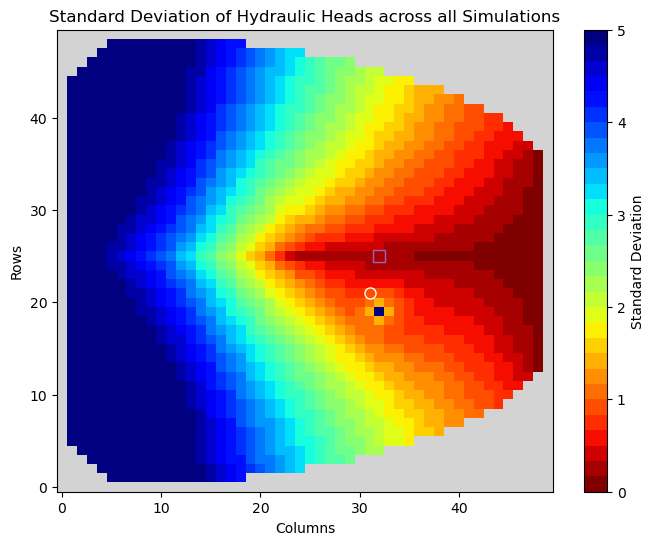

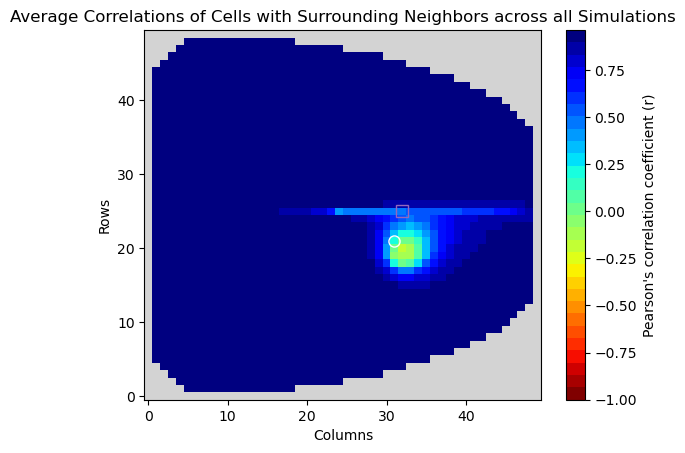

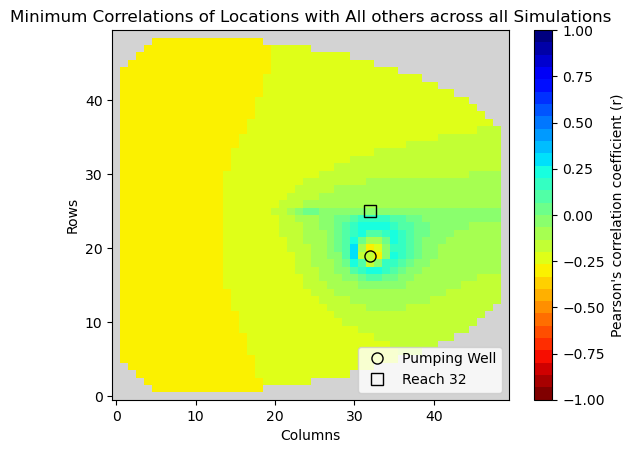

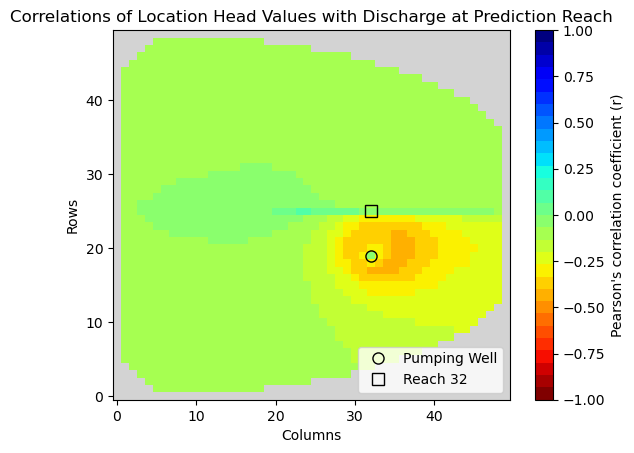

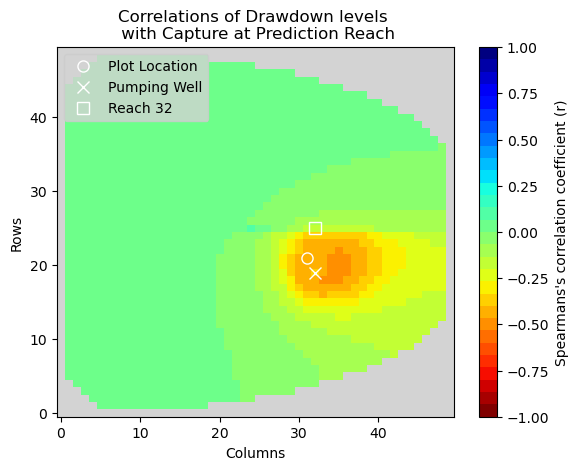

In [73]:
wn = 844
print("well num, well col, well row \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]))

ztop = np.genfromtxt('base/base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)


kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)

# print(well_head_var)
wellmesh = np.ndarray((50,50))
wellmesh[:][:] = -1e30

wellmesh2 = wellmesh.copy()
mesh_feat_to_target = wellmesh.copy()
wellmesh_corr = wellmesh.copy()
minmesh = wellmesh.copy()
spearmans_feat_to_target = wellmesh.copy()

from spotpy.objectivefunctions import correlationcoefficient as r

#new_zone_q = ReachQdf.loc[well_head_noRiv.index]

rn = 32

#LastStpHeads = well_head_df.loc[:,idx[:,StrPer[-1]]]

#outputs = RevisedOutputdf.loc[idx[StrPer[-1],:],rn].unstack('Stp')

outputs = outputsdf[rn]

for i in range(all_well_loc.shape[0]):
    
    wellmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].std()
    mesh_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = r(outputs.values.flatten(),LastStpHeads[str(i)].values.flatten())
   # wellmesh2[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = LastStpHeads[str(i)].mean() - ztop[int(all_well_loc[i, 0]),int(all_well_loc[i, 1])]
    wellmesh_corr[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[str(i)].mean()
    minmesh[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = corrmatrix[str(i)].min()
    
    rho, p = stats.spearmanr(outputs.values.flatten(),LastStpHeads[str(i)].values.flatten())
    spearmans_feat_to_target[int(all_well_loc[i, 1]),int(all_well_loc[i, 0])] = rho


    
cmap2 = cm.get_cmap("jet_r",lut=30)
cmap2.set_under("lightgray")
river = np.ndarray((48,))
river[:] = 25
plt.figure(figsize=(8,6))

reach_label = "Reach " + str(rn)

plt.pcolormesh(KK,GG,wellmesh,cmap = cmap2,vmin=0, vmax = 5,shading='nearest')
plt.colorbar(label = 'Standard Deviation')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Standard Deviation of Hydraulic Heads across all Simulations')
plt.show()


plt.pcolormesh(KK,GG,wellmesh_corr,cmap = cmap2,vmin=-1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(rn,25, marker="s", markersize=8, color="tab:purple", mfc='none', linestyle = "None", label=reach_label)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Average Correlations of Cells with Surrounding Neighbors across all Simulations')
plt.show()
# grid_z0 = griddata(wellmap[:1], wellmap[2], (KK, GG), method='nearest')

# #plt.imshow(wellmesh, cmap='RdBu')

plt.pcolormesh(KK,GG,minmesh,cmap = cmap2,vmin=-1, vmax = 1, shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Minimum Correlations of Locations with All others across all Simulations')
plt.show()

plt.pcolormesh(KK,GG,mesh_feat_to_target,cmap = cmap2, vmin = -1, vmax=1,shading='nearest')
plt.colorbar(label = 'Pearson\'s correlation coefficient (r)')
plt.plot(32,19, marker="o", markersize=8, color="k", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="k", mfc='none', linestyle = "None", label=reach_label)
plt.legend(loc='lower right')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Correlations of Location Head Values with Discharge at Prediction Reach')
plt.show()

plt.pcolormesh(KK,GG,spearmans_feat_to_target,cmap = cmap2,vmin=-1, vmax=1, shading='nearest')
plt.colorbar(label = 'Spearmans\'s correlation coefficient (r)')
plt.plot(int(all_well_loc[wn][1]), int(all_well_loc[wn][0]), marker="o", markersize=8, color="White", mfc='none', linestyle = "None", label="Plot Location")
plt.plot(32,19, marker="x", markersize=8, color="w", mfc='none', linestyle = "None", label="Pumping Well")
plt.plot(rn,25, marker="s", markersize=8, color="w", mfc='none', linestyle = "None", label=reach_label)
plt.legend(facecolor='lightgray', loc='upper left')
plt.xlabel('Columns')
plt.ylabel('Rows')

#plt.title('Winter - Correlations of Drawdown levels \n with Capture at Prediction Reach')
#plt.title('Correlations of Location Head Values \n with Discharge at Prediction Reach')
plt.title('Correlations of Drawdown levels \n with Capture at Prediction Reach')

plt.show()


In [74]:
#display(well_head_noRiv)

## Testing stacking all the stressperiods together to increase the sample sizes
# Stp_head_test_df = well_head_noRiv.copy()
# noRivWellsInt = [i for i in AllWells if i not in drop_locs[0]]

# column_idx = pd.MultiIndex.from_product([noRivWellsInt, stps_arr],
#                            names=['wellnum', 'Stp'])
# Stp_head_test_df.columns = column_idx
# # Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')
# #display(Stp_head_test_df)
# Stp_head_test_df = Stp_head_test_df.stack(level='Stp').reset_index(drop=True)
# display(Stp_head_test_df)
# output_test = RevisedOutputdf.swaplevel(0,1).sort_index(0)
# #display(RevisedOutputdf[25])
# output_test = output_test.reset_index(drop=True)
# #display(RevisedOutputdf.loc[idx[:,1],25])

# Stp_head_test_df.columns = Stp_head_test_df.columns.astype('str')

### Decision Tree Code

In [75]:
#best_pars_dt = {'min_samples_split': 15, 'min_samples_leaf': 5, 'min_impurity_decrease': 15, 'max_leaf_nodes': 234, 'max_depth': 8, 'criterion': 'squared_error','random_state': 29}
best_pars_dt = {'splitter': 'best','max_features': 1.0,'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_leaf_nodes': 52, 'max_depth': 6, 'criterion': 'friedman_mse'}

#Previous
#best_pars_dt = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1.0, 'max_depth': 7, 'criterion': 'friedman_mse', 'random_state':1}

In [76]:
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n = 1

random_state = 29

rn = 32
#strper_num = 0
#StrPer = [i+1 for i in range(stps, stps+numTS)]

# #take the last stress period (-1) - welldf columns are strings 
# SingleStpHeads = well_head_noRiv.loc[:,idx[:,StrPer[-1]]]
# SingleStpHeads.columns = SingleStpHeads.columns.droplevel('Stp').astype('str') #have to do this for the TreeRegressor to keep the wellnums

# outputs = RevisedOutputdf.loc[idx[StrPer[-1],:],rn].unstack('Stp')
# #display(outputs)
outputs = outputsdf[rn]

imp_df, metrics_df, impurity, Tree, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, LastStpHeads, outputs, best_pars_dt, 0.2, n, random_state)  

#imp_df, metrics_df, y_test, y_pred = trainAndEvaluateModel(DecisionTreeRegressor, Stp_head_test_df, outputs[rn], best_pars_dt, 0.2, n)  

print('Total time: ' + str(time.time()-t0))


Shape of Input Samples: (713, 2012)
Shape of Output Targets: (713,)
Total time: 1.2015867233276367


       bias        rmse         r       nse  lognse      kge
0 -1.489937  448.465845  0.644725  0.397744  0.4522  0.57954


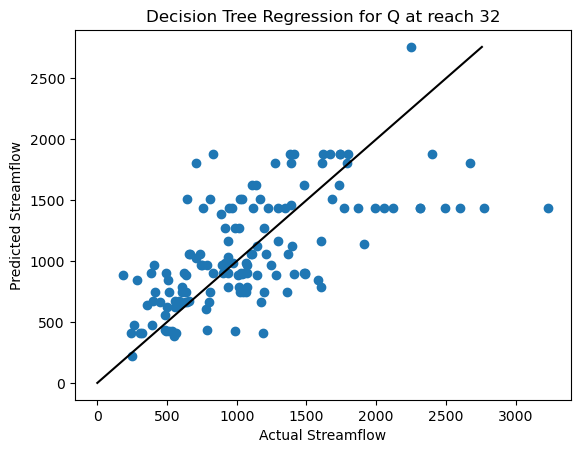

[0.31427429924037853, 0.1645894794504071, 0.14090243945248795]


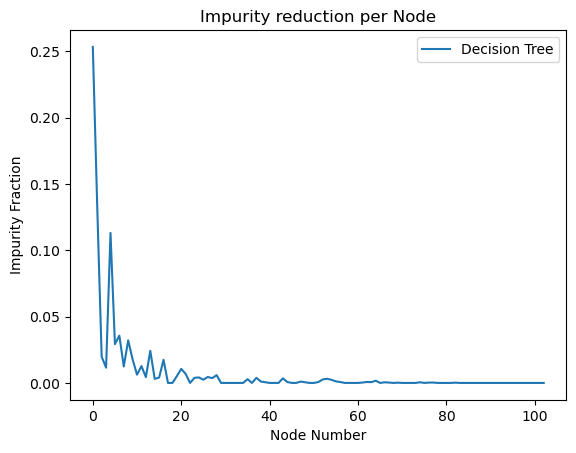

In [77]:
print(metrics_df)
# display(imp_df)
# test = imp_df.copy().T
#test.columns =Stp_head_test_df.columns
#test.columns = well_head_noRiv.columns
#test = pd.DataFrame(test.sum(axis = 0) / n)

#display(test)


# #imp_df.to_pickle('Drawdown_DT_Impdf.pkl')
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_pred.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)
plt.show()

import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import quickEvalTree

impurity_df = pd.DataFrame(impurity).fillna(0)
avg_impurity = impurity_df.mean(axis = 0)

#print(Tree.max_features_)
#print(Tree.n_features_in_)
print(sorted(Tree.feature_importances_, reverse=True)[:3])
from treeFuncs import evalTree
imp_improv = quickEvalTree(Tree)

plt.plot(imp_improv, label = "Decision Tree")
#plt.plot(rand_imp_improv, label ="Random Tree")
#plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity Fraction')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)

## Random Feature Tree

Shape of Input Samples: (713, 2012)
Shape of Output Targets: (713,)
Total time: 13.566991567611694
bias        3.120673
rmse      530.534672
r           0.412843
nse         0.152651
lognse      0.158017
kge         0.267111
dtype: float64


Text(0.5, 1.0, 'Example Random Decision Tree Regression for Q at reach 32')

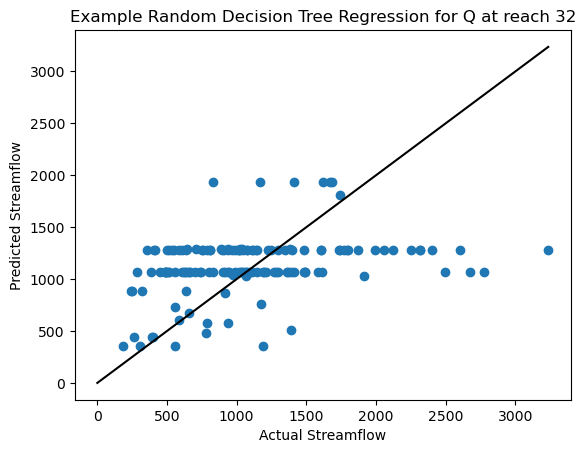

In [78]:
# RANDOM Feature Tree 
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()


#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
best_pars_dt_rand = {'splitter': 'best','max_features': 1,'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 25, 'max_leaf_nodes': 52, 'max_depth': 6, 'criterion': 'friedman_mse'}

#best_pars_dt_rand = {'splitter': 'best', 'min_samples_split': 15, 'min_samples_leaf': 2, 'min_impurity_decrease': 35, 'max_leaf_nodes': 263, 'max_features': 1, 'max_depth': 7, 'criterion': 'friedman_mse'}
    
n=100
imp_df_rand, metrics_df_rand, rand_impurity_list, randTree, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, LastStpHeads, outputs, best_pars_dt_rand, 0.2, n, random_state)  

#imp_df_rand, metrics_df_rand, y_test, y_pred = trainAndEvaluateModel(ExtraTreeRegressor, Stp_head_test_df, output_test[rn], best_pars_dt_rand, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rand.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Example Random Decision Tree Regression for Q at reach " + str(rn)
plt.title(title)

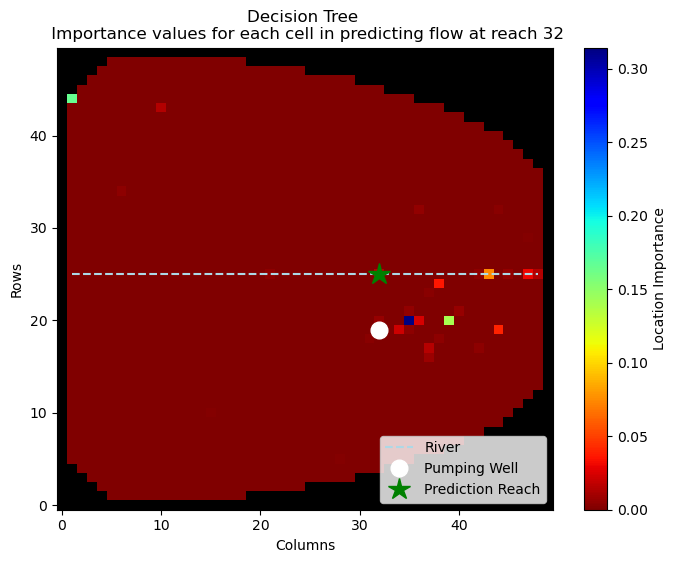

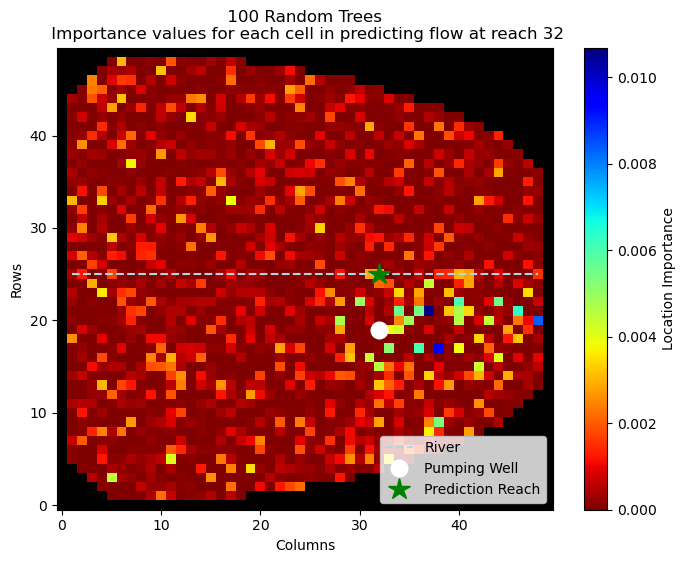

In [79]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1

title = 'Decision Tree \n Importance values for each cell in predicting flow at reach ' + str(rn)
#wellmesh_df = np.ndarray((len(StrPer),50,50))


#for k,i in enumerate(StrPer):
 #   wellmesh_df[k] = plotImportance(test.xs(i,level='Stp'),SingleStpHeads, well_loc_df,numTS,n,rn,title)
wellmesh_df = plotImportance(imp_df,LastStpHeads, well_loc_df,numTS,1,rn,title)

title_rand = ' 100 Random Trees \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_rand = plotImportance(imp_df_rand,LastStpHeads, well_loc_df,numTS,100,rn,title_rand)


94
          0         1         2         3         4         5         6   \
0   0.054949  0.004199  0.063100  0.016652  0.002780  0.011641  0.000000   
1   0.077861  0.072263  0.010521  0.004764  0.021776  0.040191  0.043918   
2   0.054949  0.001565  0.058921  0.017808  0.001065  0.007715  0.010777   
3   0.047091  0.020152  0.003085  0.009349  0.008579  0.003276  0.031287   
4   0.056842  0.002370  0.063142  0.010599  0.002861  0.000815  0.057771   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.044292  0.065785  0.007855  0.001367  0.009716  0.009771  0.000000   
96  0.060765  0.041892  0.008537  0.114610  0.006400  0.036005  0.043405   
97  0.056521  0.003426  0.062970  0.019084  0.002585  0.009131  0.008284   
98  0.054949  0.005624  0.062765  0.011310  0.008901  0.001218  0.167809   
99  0.047617  0.030225  0.009108  0.016583  0.005283  0.000672  0.002049   

          7         8         9   ...   87   88   89   90   91   92   93   94  \
0  

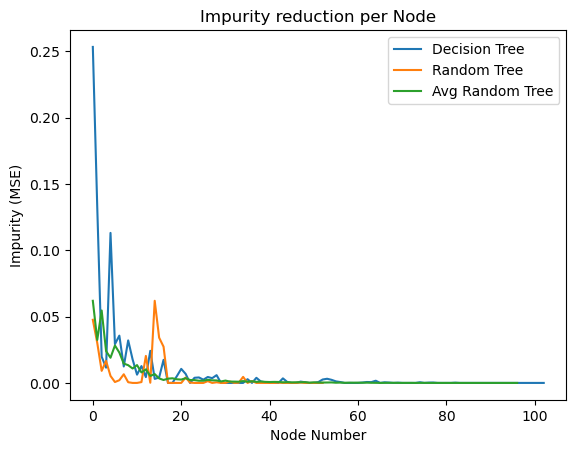

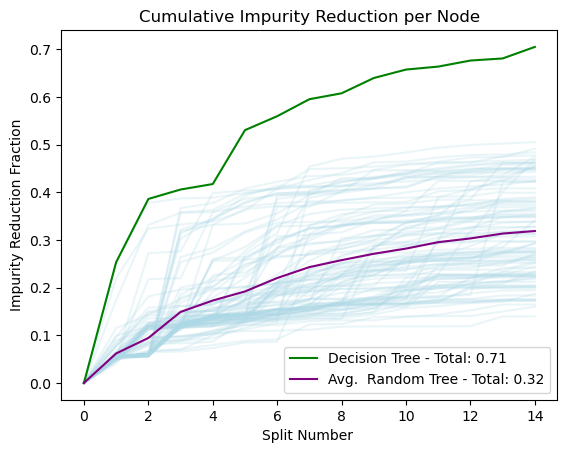

In [80]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import evalTree

impurity_df = pd.DataFrame(rand_impurity_list).fillna(0)
avg_rand_impurity = impurity_df.mean(axis = 0)

max_rand_idx = impurity_df.iloc[:,:2].sum(axis=1).idxmax()
print(max_rand_idx)
print(impurity_df)
max_rand_impurity = impurity_df.loc[max_rand_idx]

min_rand_idx = impurity_df.sum(axis = 1).idxmin()
min_rand_idx = impurity_df[0].idxmin()

min_rand_impurity = impurity_df.loc[min_rand_idx]
#display(impurity_df)
#print(Tree.max_features_)
#print(Tree.n_features_in_)
#print(sorted(randTree.feature_importances_, reverse=True)[:3])
#from treeFuncs import evalTree
rand_imp_improv = quickEvalTree(randTree)

plt.plot(imp_improv, label = "Decision Tree")
plt.plot(rand_imp_improv, label ="Random Tree")
plt.plot(avg_rand_impurity, label ="Avg Random Tree")
plt.title('Impurity reduction per Node')
plt.ylabel('Impurity (MSE)')
plt.xlabel('Node Number')
plt.legend()
#help(tree._tree.Tree)
plt.show()

#quick cumulative function that inserts 0 at beginning 
def cumImpurity(imp):
    nodes = 15
    return np.cumsum(np.insert(imp,0,0))[:nodes] #inserting 0 at the beginning - essentially to indicate the original impurity reduction (0)



dt_impurity_cumulative = cumImpurity(imp_improv)
#rand_impurity_cumulative = cumImpurity(rand_imp_improv)[:50]
avgrand_impurity_cumulative = cumImpurity(avg_rand_impurity.to_numpy())
#maxrand_impurity_cumulative = cumImpurity(max_rand_impurity.to_numpy())
minrand_impurity_cumulative = cumImpurity(min_rand_impurity.to_numpy())
x_nodes = np.arange(len(minrand_impurity_cumulative))
          
for i in range(100):
    single_impurity = cumImpurity(impurity_df.loc[i].to_numpy())
    plt.plot(single_impurity, color='lightblue', alpha = 0.25)
    
plt.plot(dt_impurity_cumulative, markersize = 4, color='g', label = "Decision Tree - Total: {:.2f}".format(np.max(dt_impurity_cumulative)))
#plt.plot(rand_impurity_cumulative, markersize = 4, marker= 'o', label ="Random Tree - Total: {:.2f}".format(np.max(rand_impurity_cumulative)))
plt.plot(avgrand_impurity_cumulative, markersize = 4, color='purple', label ="Avg.  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
#plt.fill_between(x_nodes,maxrand_impurity_cumulative, minrand_impurity_cumulative, alpha = 0.2, label ="Min and Max Random Tree")
#plt.plot(maxrand_impurity_cumulative, markersize = 4,marker='.', label ="Max  Random Tree - Total: {:.2f}".format(np.max(avgrand_impurity_cumulative)))
    
plt.title('Cumulative Impurity Reduction per Node')
plt.ylabel('Impurity Reduction Fraction')
plt.xlabel('Split Number ')
plt.xticks(minor=True)
plt.legend(loc='lower right')

## Gradient Boosting

In [81]:
#new pars - from DIFF analysis
best_pars_gr = {'subsample': 0.9, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 15, 'max_leaf_nodes': 154, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.11, 'criterion': 'friedman_mse'}
best_pars_gr={'subsample':1.0,'n_estimators': 40, 'min_samples_split': 25, 'min_samples_leaf': 2, 'min_impurity_decrease': 100, 'max_leaf_nodes': 136, 'max_depth': 8, 'loss': 'squared_error', 'criterion': 'squared_error'}


Shape of Input Samples: (713, 2012)
Shape of Output Targets: (713,)
Total time: 88.28779077529907
bias        0.999645
rmse      297.983227
r           0.859333
nse         0.734108
lognse      0.696320
kge         0.752147
dtype: float64


Text(0.5, 1.0, 'Gradient Boosting Tree Regression for Q at reach 32')

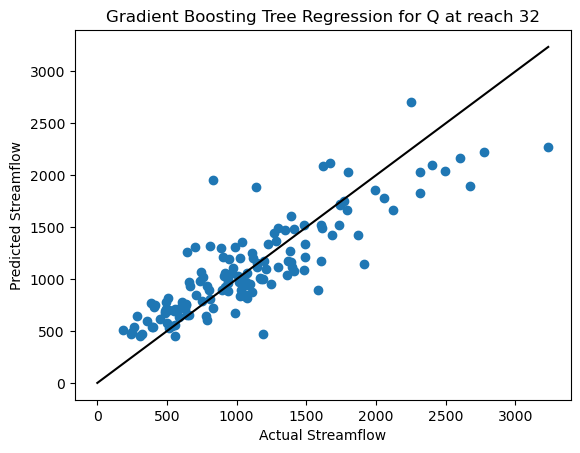

In [82]:
# Split dataset into training set and test set, default here is 30% test
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import trainAndEvaluateModel

t0 = time.time()
n = 1

#Splitter is random and max features is set to 1, note that 1.0 is all in the new Sklearn so this is a little confusing
    
#imp_df_gr, metrics_df_gr, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, Stp_head_test_df, output_test[rn], best_pars_gr, 0.2, random_state)  

imp_df_gr, metrics_df_gr, gr_impurity, gr_tree, y_test, y_pred = trainAndEvaluateModel(GradientBoostingRegressor, LastStpHeads, outputs, best_pars_gr, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_gr.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1
plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Gradient Boosting Tree Regression for Q at reach " + str(rn)
plt.title(title)

# meshtitle = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

# wellmesh_gr = plotImportance(imp_df_gr,SingleStpHeads, well_loc_df,1,1,rn,meshtitle)

In [83]:
#gr_imp_df.to_pickle('Drawdown_GB_Impdf.pkl')
treeimp = pd.DataFrame(gr_tree.feature_importances_)
#display(treeimp)
topFeats = treeimp[0].nlargest(5)
topFeatLocs = Tree.feature_names_in_[topFeats.index]
display(topFeats)
display(topFeatLocs)
display(well_loc_df.loc[topFeatLocs.astype('int')])

display(imp_df_gr)
MostImp = []
for i in range(n):
    MostImp.append(int(imp_df_gr[i].idxmax()))

locs, counts = np.unique(MostImp,return_counts=True)
print(locs,counts)
display(well_loc_df.loc[locs])

800     0.215987
804     0.088863
801     0.053752
1051    0.030284
1950    0.026571
Name: 0, dtype: float64

array(['800', '804', '801', '1051', '1950'], dtype=object)

,0,1
800,20,35
804,20,39
801,20,36
1051,25,46
1950,46,3


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2007,0.0
2008,0.0
2009,0.0
2010,0.0


[800] [1]


,0,1
800,20,35


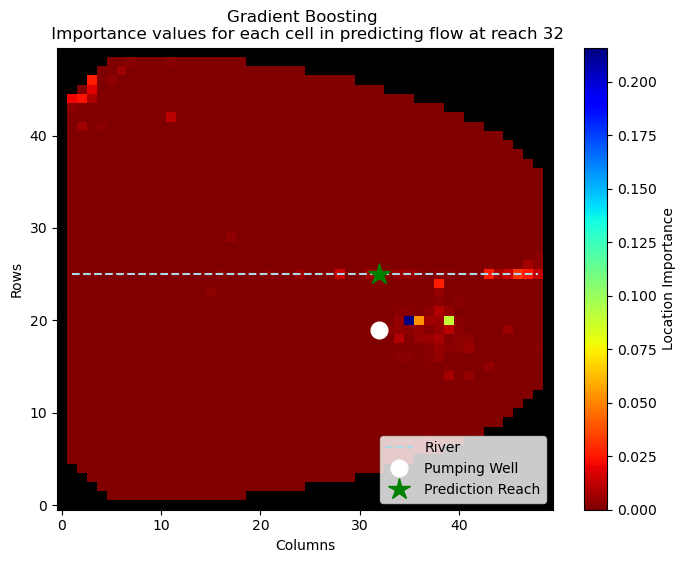

In [84]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Gradient Boosting \n Importance values for each cell in predicting flow at reach ' + str(rn)

wellmesh_gr = plotImportance(imp_df_gr,LastStpHeads, well_loc_df,1,1,rn,title)



## Random Forest 

In [82]:
#Creating the diff well heads by subtracting off the first steady state pumping period
#lastStp df is in name only and represents the heads at the designated stpNum
stpNum = -1

firstStp = well_head_noRiv.loc[:,idx[:,StrPer[0]]].droplevel(level=1,axis=1)
lastStp = well_head_noRiv.loc[:,idx[:,StrPer[stpNum]]].droplevel(level=1,axis=1)

diffStpHeads = firstStp.sub(lastStp)
diffStpHeads.columns = diffStpHeads.columns.astype('str') #have to do this for the trees to remember the wellnums

firstStpOutputs = RevisedOutputdf.loc[idx[StrPer[0],:],:].droplevel(level=0,axis=0)
lastStpOutputs = RevisedOutputdf.loc[idx[StrPer[stpNum],:],:].droplevel(level=0,axis=0)
diffOutputs = firstStpOutputs.sub(lastStpOutputs)
#

#settingthe Heads
#LastStpHeads = lastStp.copy()
LastStpHeads = diffStpHeads.copy()

#setting the outputs (diffOutputs for Capture)
outputsdf = diffOutputs.iloc[1:].copy()  #Drop the 0th run for seasonal - not sure how it snuck through
#outputsdf = lastStpOutputs.copy()


In [83]:
#new best RF
#best_pars_rf = {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 5, 'max_samples': 0.9, 'max_leaf_nodes': None, 'max_depth': 7, 'criterion': 'squared_error'}
best_pars_rf = {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 75, 'max_samples': 0.7, 'max_leaf_nodes': None, 'max_depth': 6, 'criterion': 'squared_error'}

Shape of Input Samples: (630, 1824)
Shape of Output Targets: (630,)
Total time: 24.161749124526978
bias        0.349105
rmse      465.528156
r           0.877210
nse         0.755925
lognse      0.598144
kge         0.731170
dtype: float64


Text(0.5, 1.0, 'Random Forest Regression for predicting Q at reach 32')

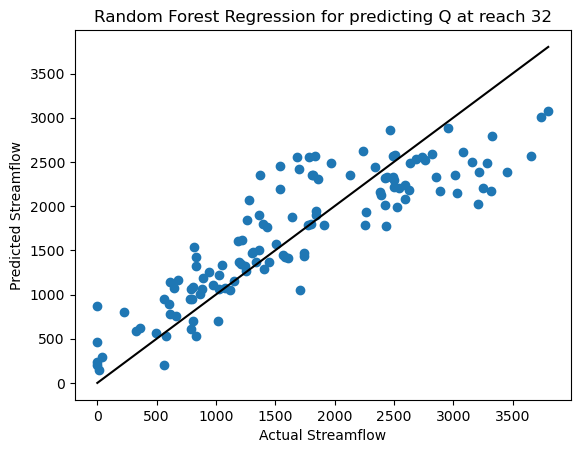

In [84]:
# Split dataset into training set and test set, default here is 30% test
t0 = time.time()
n=1

#22, 27, 32, 37, 42  
rn = 32
random_state = 29
outputs = outputsdf[rn]

#Splitter is random and max features is set to 1 (note that 1.0 is all in the new default all features in Sklearn so this is a little confusing)   
#imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, Stp_head_test_df, output_test[rn], best_pars_rf, 0.2, n, random_state)  
imp_df_rf, metrics_df_rf, impurity_list, rf_Tree, y_test, y_pred = trainAndEvaluateModel(RandomForestRegressor, LastStpHeads, outputs, best_pars_rf, 0.2, n, random_state)  

t1 = time.time()

total = t1-t0
print('Total time: ' + str(total))

#print('Fraction of wet simulations: ' + str(len(new_zone_q[new_zone_q[rn]> 0].index) / len(new_zone_q.index)))

#print(metrics_df_rand.mean(),metrics_df_rand.std())
print(metrics_df_rf.mean())
plt.figure()
plt.scatter(y_test, y_pred)
outmax = np.max(y_test.max()) +1

plt.plot([0, outmax], [0, outmax], color='k', linestyle='-')

plt.xlabel("Actual Streamflow")
plt.ylabel("Predicted Streamflow")
title = "Random Forest Regression for predicting Q at reach " + str(rn)
plt.title(title)

C:\Users\davem\Documents\Thesis\mf-trees\treeFuncs.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = cm.get_cmap("Blues")#,lut=20)


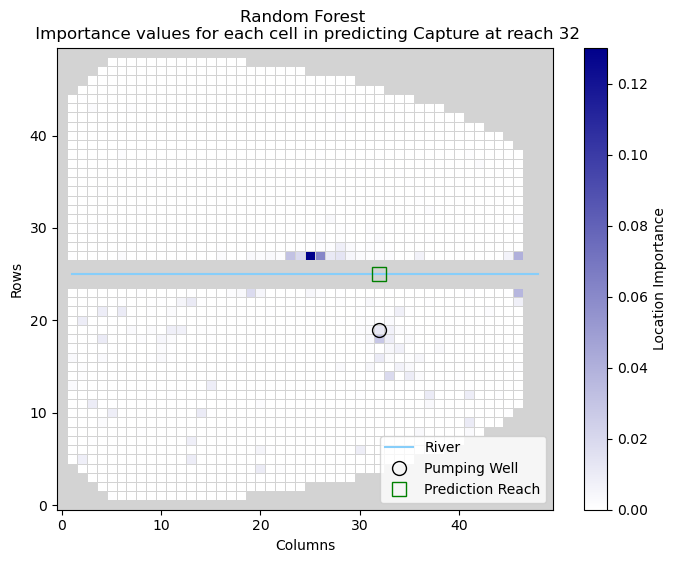

In [85]:
import importlib
import treeFuncs
importlib.reload(treeFuncs)
from treeFuncs import plotImportance

numTS = 1
#n = 100

title = 'Random Forest \n Importance values for each cell in predicting Capture at reach ' + str(rn)# + '\n RMSE: ' + str(RF_rmse)
#title = None
wellmesh_rf = plotImportance(imp_df_rf,LastStpHeads, well_loc_df,numTS,n,rn,title)

[[0.96862745 0.98823529 0.96078431 1.        ]
 [0.96419839 0.98651288 0.95561707 1.        ]
 [0.95976932 0.98479047 0.95044983 1.        ]
 ...
 [0.03137255 0.2044752  0.44372165 1.        ]
 [0.03137255 0.19635525 0.43166474 1.        ]
 [0.03137255 0.18823529 0.41960784 1.        ]]


[Text(0.0, 0, ''),
 Text(0.15, 0, 'Random Forest'),
 Text(0.5, 0, 'Gradient Boosted'),
 Text(0.85, 0, 'Decision Tree'),
 Text(1.0, 0, '')]

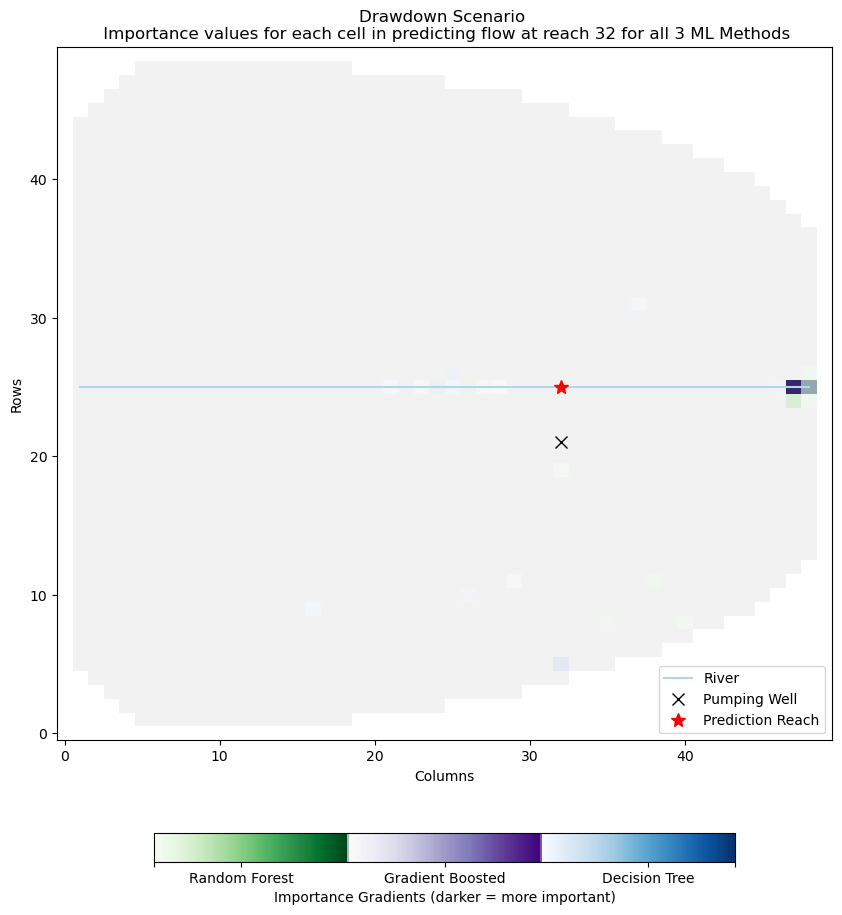

In [37]:
#set up the meshgrid   
kk = np.arange(0,50)
gg = np.arange(0,50)
GG, KK = np.meshgrid(gg,kk)



river = np.ndarray((48,))
river[:] = 25

cmap_bd = cm.get_cmap("gray")#,lut=20)
cmap_bd.set_under("w")
cmap_bd.set_over("k")
wellmesh_bd = np.ndarray((50,50))
wellmesh_bd[:,:] = -1e30
for k in range(len(all_well_loc)):
        wellmesh_bd[int(all_well_loc[k, 1]), int(all_well_loc[k, 0])] = 2

cmap_rf = mp.colormaps.get_cmap("Greens")
wellmesh_rf_masked = np.ma.masked_array(wellmesh_rf, wellmesh_rf < 0.01)
vmaxrf = np.max(wellmesh_rf)

cmap_gr = mp.colormaps.get_cmap("Purples")
wellmesh_gr_masked = np.ma.masked_array(wellmesh_gr, wellmesh_gr < 0.01)
vmaxgr = np.max(wellmesh_gr)

cmap_dt = mp.colormaps.get_cmap("Blues")
wellmesh_dt_masked = np.ma.masked_array(wellmesh_df, wellmesh_df < 0.01)
vmaxdt = np.max(wellmesh_df)

vmin = 0.01
# combine them and build a new colormap
colors = np.vstack((cmap_rf(np.linspace(0.,1,128)), cmap_gr(np.linspace(0.,1,128)), cmap_dt(np.linspace(0.,1,128))))
print(colors)

mymap = mp.colors.LinearSegmentedColormap.from_list('Merged',colors)
fig, axs = plt.subplots(figsize=(10,12))
#plt.figure(figsize=(8,10))
alpha = 0.6
axs.pcolormesh(KK,GG,wellmesh_bd,vmax = 1.5,vmin = vmin, cmap = cmap_bd, shading='nearest', alpha = 0.05)
axs.pcolormesh(KK,GG,wellmesh_dt_masked,vmax = vmaxdt, vmin = vmin, cmap = cmap_dt, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Decision Tree", shrink = 0.25, pad = 0.05, anchor = (0,0.25), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_rf_masked,vmax = vmaxrf, vmin = vmin, cmap = cmap_rf, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Random Forest", shrink = 0.25, anchor = (0.3,0.75), location ='bottom').set_ticks([])
axs.pcolormesh(KK,GG,wellmesh_gr_masked,vmax = vmaxgr, vmin = vmin, cmap = cmap_gr, shading='nearest', alpha = alpha)
#plt.colorbar(label = "Gradient Boosted", shrink = 0.25, anchor = (0.75,1), location ='bottom').set_ticks([])
#plt.colorbar(cmap = mymap, location = 'bottom')


axs.plot(range(1,49),river, color="lightblue", label='River')
axs.plot(32, 21, marker="x", markersize=8, color="Black", linestyle = "None", label="Pumping Well")
axs.plot(rn, 25, marker="*", markersize=10, color="Red", linestyle = "None",label="Prediction Reach")
axs.set_xlabel('Columns')
axs.set_ylabel('Rows')
axs.set_title('Drawdown Scenario \n Importance values for each cell in predicting flow at reach ' + str(rn) + ' for all 3 ML Methods')
axs.legend(loc="lower right")
#axs[1].axis('off')
cbar = fig.colorbar(mp.cm.ScalarMappable(cmap=mymap), drawedges = False, ax = axs,label = 'Importance Gradients (darker = more important)', orientation = 'horizontal', ticks = [0,0.15,0.5,0.85,1],pad = 0.1, shrink = 0.75)
cbar.ax.set_xticklabels(['','Random Forest', 'Gradient Boosted','Decision Tree',''])
#plt.legend()

well num, well col, well row, rf importance 

845 21 32 0.0
well num, well col, well row 

605 16 32 0.27


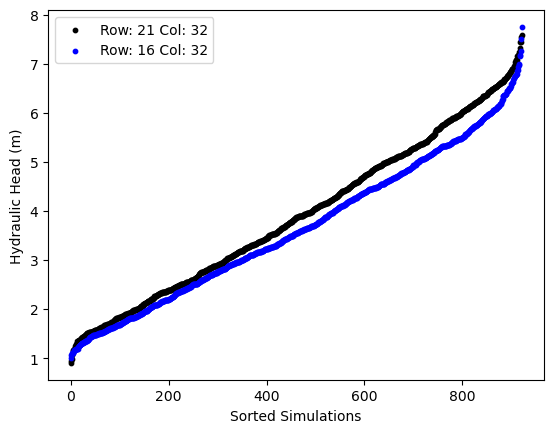

In [111]:
#Extra Plotting of well head data to examine head values in head difference cells 
#701 is row 18, col 32 
#605 is row 16, col 32 - commonly most important

wn = 701
wn = 845
print("well num, well col, well row, rf importance \n")
print(wn,int(all_well_loc[wn][0]), int(all_well_loc[wn][1]),round(imp_df_rf.loc[str(wn)][0],3))

wn2 = 605
print("well num, well col, well row \n")
print(wn2,int(all_well_loc[wn2][0]), int(all_well_loc[wn2][1]),round(imp_df_rf.loc[str(wn2)][0],3))

label_str = "Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1])
label_str2 = "Row: " +str(all_well_loc[wn2][0])+ " Col: " + str(all_well_loc[wn2][1])

plt.scatter(range(len(LastStpHeads[str(wn)].index)),LastStpHeads[str(wn)].sort_values(), s = 10, c='k', label = label_str)
plt.scatter(range(len(LastStpHeads[str(wn2)].index)),LastStpHeads[str(wn2)].sort_values(), s = 10, c='b',label= label_str2)

plt.xlabel('Sorted Simulations')
plt.ylabel('Hydraulic Head (m)')
#plt.title("Location Head Values across All Steady State Simulations")# \n at Row: " +str(all_well_loc[wn][0])+ " Col: " + str(all_well_loc[wn][1]))
plt.legend()
plt.show()
          

Low_K_ratio


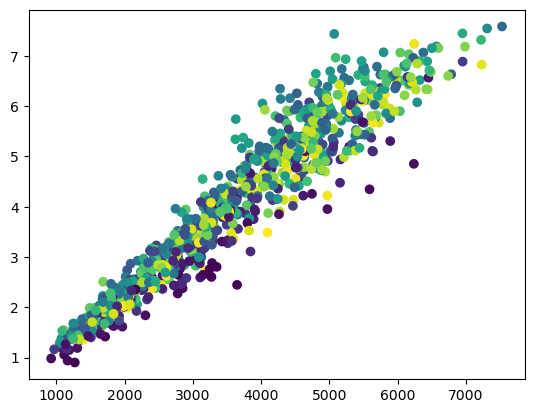

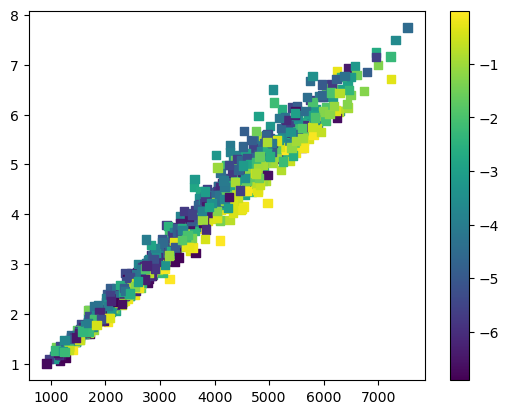

Sy


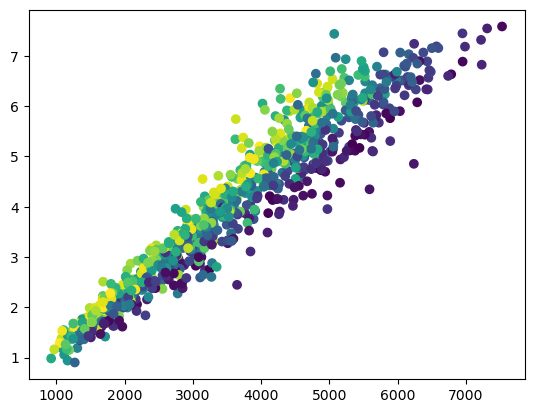

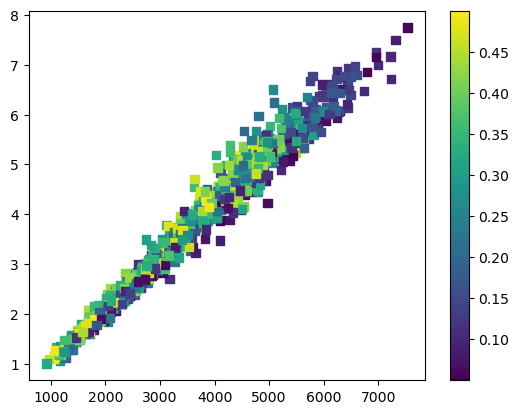

Rech


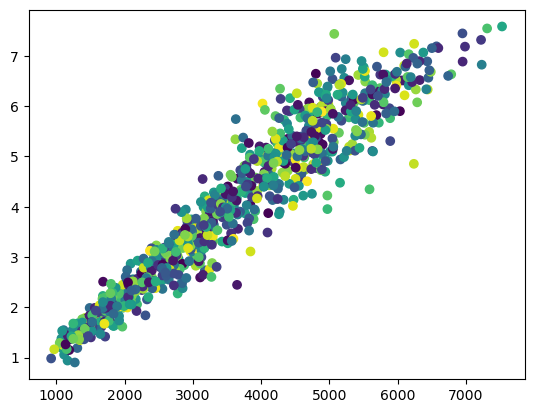

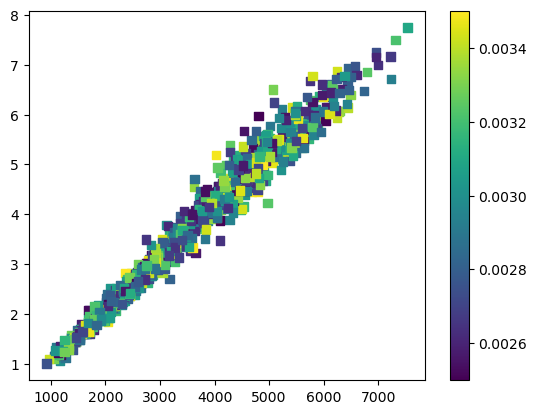

ET_valley


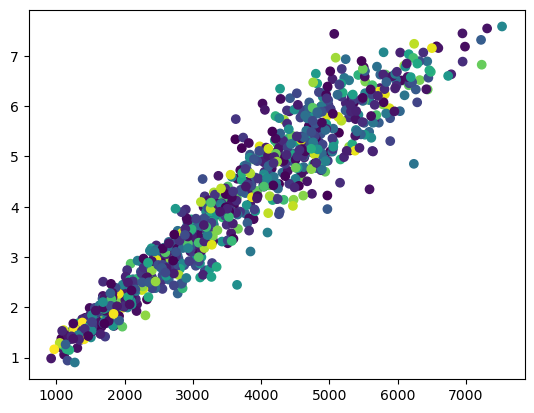

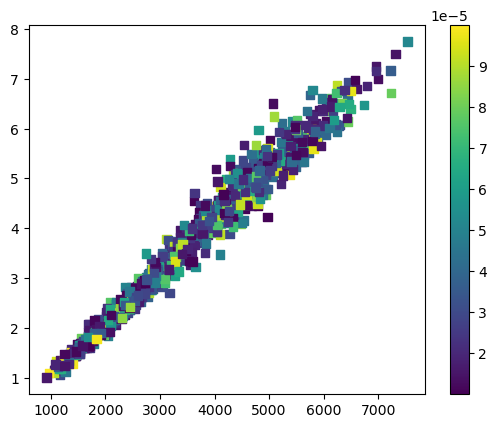

ET_rip_ratio


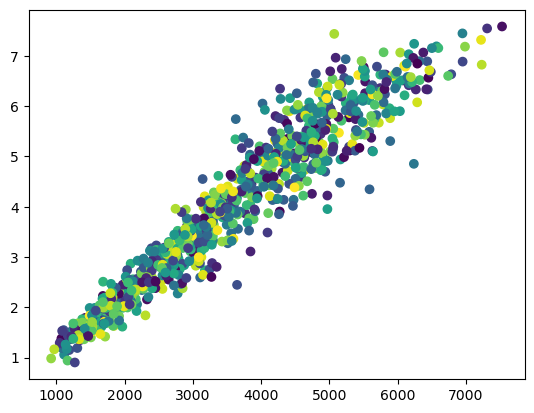

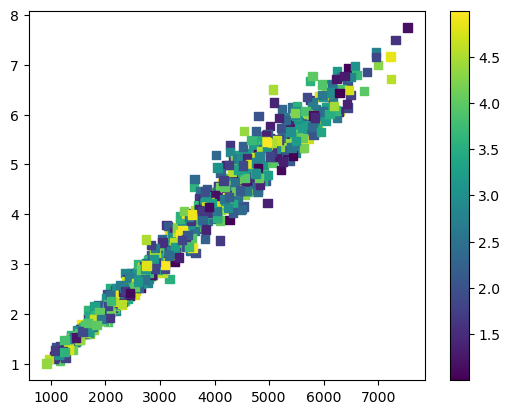

Stream_K_ratio


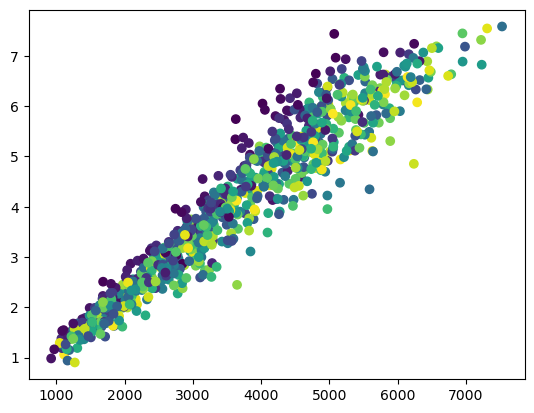

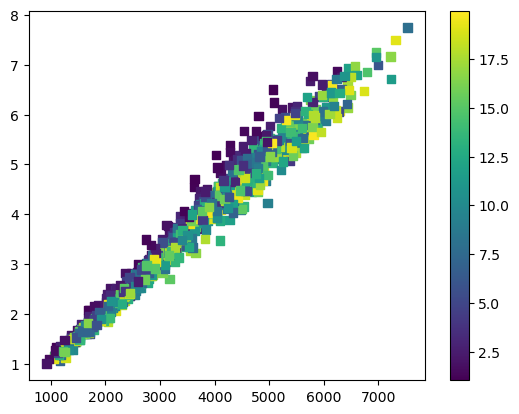

Pumping Rate


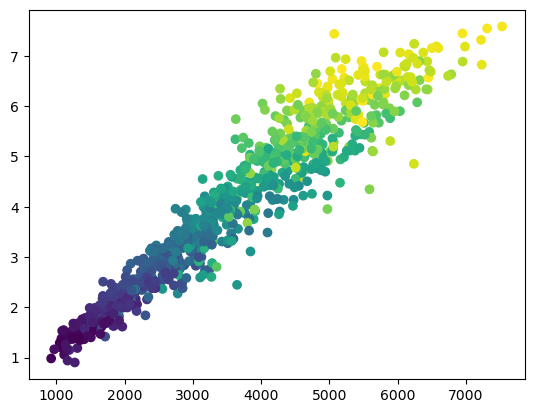

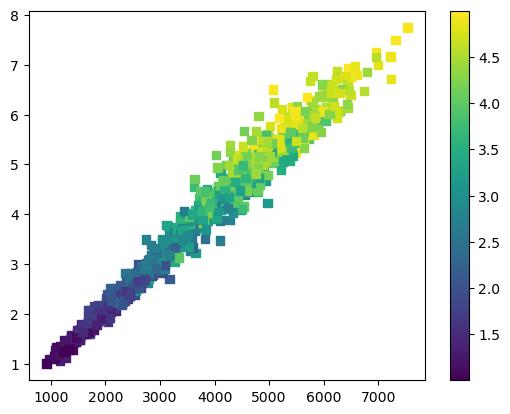

In [121]:
#PLotting outputs above with outflows 
#display(pardf)
for i in pardf.columns[1:]:
    print(i)
    if i == 'Low_K_ratio':
        z = np.log(pardf[i])
    else:
        z = pardf[i]
    plt.scatter(outputsdf[rn],LastStpHeads[str(wn)], c=z, cmap=cm.viridis)
    plt.show()
    
    plt.scatter(outputsdf[rn],LastStpHeads[str(wn2)],marker='s', c=z, cmap=cm.viridis)
    cbar = plt.colorbar()
    plt.show()
#plt.scatter(outputsdf[rn],LastStpHeads[str(wn)],c=pardf['Pumping Rate'], cmap=cm.hsv)
#cbar= plt.colorbar()
